In [7]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

base_path = "iam-handwriting-word-database"
words_list = []

words = open(f"{base_path}/words_new.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

split_idx = int(0.7 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f"Total: {len(train_samples) + len(validation_samples) + len(test_samples)}")

base_image_path = os.path.join(base_path, "iam_words/words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(char_to_num.get_vocabulary())

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

"""
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image
"""

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [image_height, image_width])
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image /= 255.0  # Normalize to [0,1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label} #image, label #{"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Total training samples: 26813
Total validation samples: 5746
Total test samples: 5746
Total: 38305
Maximum length:  19
Vocab size:  76
['[UNK]', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [18]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Initialize SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Initialize lists to store descriptors and labels
descriptors = []
labels2 = []

# Extract SIFT features from images
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    for image, label in zip(images, labels):
        image = tf.image.flip_left_right(image)
        image = tf.transpose(image, perm=[1, 0, 2])
        image = (image * 255.0).numpy().clip(0, 255).astype(np.uint8)
        image = image[:, :, 0]
        
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        #label = tf.strings.unicode_decode(label, 'UTF-8')
        labels2.append(label)
        
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptors.extend(des)
        

# Cluster descriptors using K-Means
kmeans = KMeans(n_clusters=len(char_to_num.get_vocabulary())-1)
kmeans.fit(descriptors)

# Create BoW vectors for images
bow_vectors = []
for des in descriptors:
    histogram = np.zeros(len(char_to_num.get_vocabulary())-1)
    des_float = des.astype(np.float32)
    des_2d = des_float.reshape(1, -1).astype('double')
    
    clusters = kmeans.predict(X=des_2d)
    
    for cluster in clusters:
        histogram[cluster] += 1
    bow_vectors.append(histogram)

# Normalize BoW vectors
scaler = StandardScaler()
bow_vectors = scaler.fit_transform(bow_vectors)

# Train classifier
clf = SVC()
clf.fit(bow_vectors[:64], labels2)

SVC()

ValueError: X has 12288 features, but PCA is expecting 76 features as input.

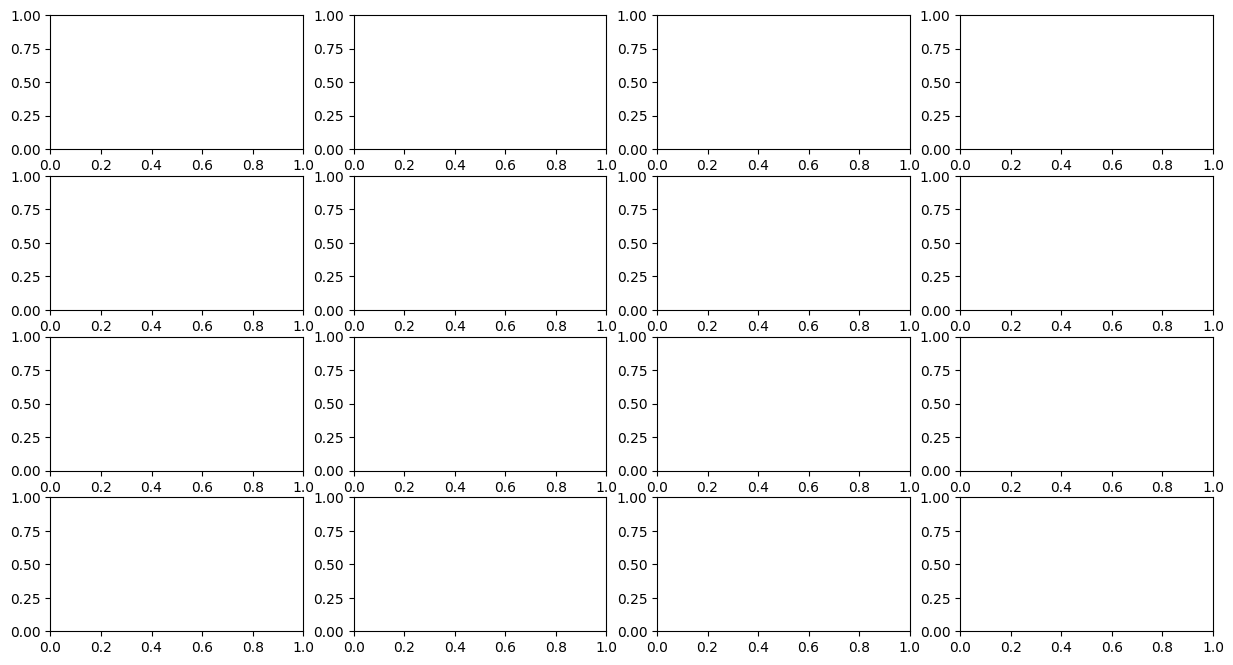

In [22]:
def calculate_match_percentage(actual, predicted):
    if len(actual) == 0:
        return 0.0
    match = sum([1 for a, b in zip(actual, predicted) if a == b])
    return match / len(actual)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    batch_images_2d = tf.reshape(batch_images, [batch_images.shape[0], -1])

    batch_images_2d = batch_images_2d.numpy()
    
    from sklearn.decomposition import PCA

    # Create a PCA object
    pca = PCA(n_components=76)
    
    # Fit the PCA object on your training data (bow_vectors) and then apply it to batch_images_2d
    pca.fit(bow_vectors)
    batch_images_2d_reduced = pca.transform(batch_images_2d)
    
    preds = clf.predict(batch_images_2d)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(16):
        img = batch_images[i]
        #img = tf.image.flip_left_right(img)
        #img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        # Convert to string.
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]}\nActual: {batch_label}\nMatch: {calculate_match_percentage(batch_label, pred_texts[i]) * 100:.2f}%\nLevenshtein Distance: {levenshtein_distance(batch_label, pred_texts[i])}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()